Test the admin-only non-first-term model that only includes course-specific, subject-specific and instructor-related predictors.

In [1]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "~\\Box Sync\\Clickstream\\evaluation_results\\full\\"

In [2]:
sn_dict = {"Blue Ridge": "BRCC",
           "Central Virginia": "CVCC",
           "Dabney S. Lancaster": "DSLCC",
           "Danville": "DCC",
           "Eastern Shore": "ESCC",
           "Germanna": "GCC",
           'J. Sargeant Reynolds': "JSRCC",
           'John Tyler': "JTCC",
           "Lord Fairfax": "LFCC",
           "Mountain Empire": "MECC",
           "New River": "NRCC",
           "Northern Virginia": "NVCC",
           "Patrick Henry": "PHCC",
           "Paul D. Camp": "PDCCC",
           "Piedmont Virginia": "PVCC",
           "Rappahannock": "RCC",
           "Southside Virginia": "SSVCC",
           "Southwest Virginia": "SWVCC",
           "Thomas Nelson": "TNCC",
           "Tidewater": "TCC",
           "Virginia Highlands": "VHCC",
           "Virginia Western": "VWCC",
           "Wytheville": "WCC"}

In [3]:
df0 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\LMS_data_final.dta").loc[:,['vccsid','strm', 'college', 'course','section','grade']]
df1 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\course_specific_predictors_new.csv")
df2 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\term_specific_predictors_new.csv")
for v in [int(e) for e in np.unique(df2.cip) if e != 0]:
    df2.loc[:,'cip_'+str(v)] = (df2.cip == v).astype(int)
for v in [int(e) for e in np.unique(df2.degree_level) if e != 4]:
    df2.loc[:,'degree_level_'+str(v)] = (df2.degree_level == v).astype(int)
df2 = df2.drop(['cip', 'degree_level'], axis=1)
df3 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\cluster_specific_predictors.csv")
df4 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\instructor_related_predictors.dta")
df5 = df0.iloc[:,:5].copy()
df5.loc[:,'college_new'] = df5.college.apply(lambda x: sn_dict[x])
for sn in [e for e in sn_dict.values() if e != "BRCC"]:
    df5.loc[:,'college_'+sn] = (df5.college_new == sn).astype(int)
df5 = df5.drop(['college_new'], axis=1)
df = df0.merge(df1, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df2, how='inner', on=['vccsid','strm'])\
.merge(df3, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df4, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df5, how='inner', on=['vccsid','strm','college','course','section'])
predictors = list(df.columns)[6:]
len(predictors)

279

In [4]:
assert pd.isnull(df).any().any() == False

In [5]:
df.shape

(969025, 285)

In [6]:
train_df = df[df.strm != 2212]
test_df = df[df.strm == 2212]
original_test_grade = np.array(test_df.grade)
train_df.loc[:,'grade'] = train_df.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
test_df.loc[:,'grade'] = test_df.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
print(train_df.shape,test_df.shape)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(698361, 285) (270664, 285)


In [7]:
# Number of unique students in the sample
print(len(np.unique(train_df.vccsid)), len(np.unique(test_df.vccsid)))

164245 87022


In [8]:
print(len(np.unique(train_df.course)), len(np.unique(test_df.course)))

2246 1989


In [9]:
# Number of unique college x course observations in the sample
print(train_df.loc[:,['college', 'course']].drop_duplicates().shape[0],
      test_df.loc[:,['college', 'course']].drop_duplicates().shape[0])

7061 6037


In [10]:
# Total number of unique college x course observations in the entire sample (training + test)
print(pd.concat([train_df.loc[:,['college', 'course']], test_df.loc[:,['college', 'course']]]).drop_duplicates().shape[0])

9098


In [11]:
len(np.union1d(np.unique(train_df.course), np.unique(test_df.course)))

2639

In [12]:
predictor_category = pd.read_csv("~\\Box Sync\\Clickstream\\evaluation_results\\first\\predictor_category_table.csv")

In [18]:
predictor_df = pd.DataFrame({'predictor': predictors}).merge(predictor_category, how='inner', on=['predictor'])
predictor_df = predictor_df[predictor_df.predictor_subcategory.apply(lambda x: x in {'Course-specific', 'Course-subject-specific', 'Instructor-related'})]
predictors = list(predictor_df.predictor)
len(predictors)

238

In [19]:
def create_cv_folds(train, n_fold = 5):
    folds = []
    k_fold = StratifiedKFold(n_splits = n_fold, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grade):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        X_1 = train_part.loc[:,predictors]
        y_1 = train_part.grade
        X_2 = test_part.loc[:,predictors]
        y_2 = test_part.grade
        folds.append([(X_1.copy(),y_1.copy()),(X_2.copy(),y_2.copy())])
    return folds

In [20]:
five_folds = create_cv_folds(train_df)

In [21]:
def cross_validation_RF(rf_model, folds):
    auc_by_fold = []
    for f in folds:
        X_1 = f[0][0]
        y_1 = f[0][1]
        X_2 = f[1][0]
        y_2 = f[1][1]
        rf_model.fit(X_1,y_1)
        y_2_pred = rf_model.predict_proba(X_2)[:,1]
        auc_by_fold.append(roc_auc_score(y_2,y_2_pred))
    return round(np.mean(auc_by_fold),4)  

In [22]:
def calc_cw(y):
    # Calculate the weight of each letter grade to be used in the modeling fitting procedure: the weight is inversely proportional to the square root of the frequency of the letter grade in the training sample
    cw = Counter(y)
    class_weight = {k:np.sqrt(cw.most_common()[0][-1]/v, dtype=np.float32) for k,v in cw.items()}
    return class_weight # The output is a dictionary mapping letter grade to the corresponding weight

Max_depth = 15
Mean CV AUC: 0.7361

Max_depth = 16
Mean CV AUC: 0.7397

Max_depth = 17
Mean CV AUC: 0.7433

Max_depth = 18
Mean CV AUC: 0.7469

Max_depth = 19
Mean CV AUC: 0.7501

Max_depth = 20
Mean CV AUC: 0.7532

Max_depth = 21
Mean CV AUC: 0.7562

Max_depth = 22
Mean CV AUC: 0.759

Max_depth = 23
Mean CV AUC: 0.7615

Max_depth = 24
Mean CV AUC: 0.7641

Max_depth = 25
Mean CV AUC: 0.7664

Max_depth = 26
Mean CV AUC: 0.7686

Max_depth = 27
Mean CV AUC: 0.7707

Max_depth = 28
Mean CV AUC: 0.7724

Max_depth = 29
Mean CV AUC: 0.7743

Max_depth = 30
Mean CV AUC: 0.7759

Max_depth = 31
Mean CV AUC: 0.7771

Max_depth = 32
Mean CV AUC: 0.7787

Max_depth = 33
Mean CV AUC: 0.7802

Max_depth = 34
Mean CV AUC: 0.781

Max_depth = 35
Mean CV AUC: 0.7821



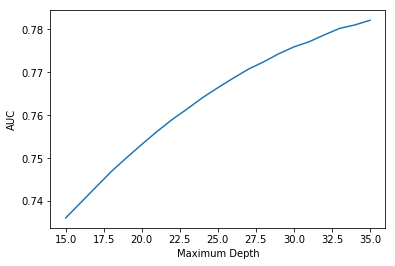

In [23]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(15,36):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(15,36),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

In [24]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(36,41):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(36,41),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

KeyboardInterrupt: 

In [25]:
### Using grid search to find the optimal number of estimators (trees)
auc_by_n = []
for n in range(100,320,20):
    rf = RandomForestClassifier(n_estimators=n, criterion="entropy", 
                                max_depth=33,
                                random_state=0, n_jobs=-1, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_n.append(auc)
    print("Number of Trees =", n)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(100,320,20), auc_by_n)
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show()

Number of Trees = 100
Mean CV AUC: 0.7784

Number of Trees = 120
Mean CV AUC: 0.7789

Number of Trees = 140
Mean CV AUC: 0.7795

Number of Trees = 160
Mean CV AUC: 0.7798

Number of Trees = 180
Mean CV AUC: 0.78

Number of Trees = 200
Mean CV AUC: 0.7802

Number of Trees = 220
Mean CV AUC: 0.7802

Number of Trees = 240
Mean CV AUC: 0.7803

Number of Trees = 260
Mean CV AUC: 0.7803

Number of Trees = 280
Mean CV AUC: 0.7803



KeyboardInterrupt: 

In [26]:
### Using grid search to find the optimal maximum number of features (trees)
auc_by_nf = []
max_nf = int(np.floor(2*np.sqrt(len(predictors))))
for nf in range(10,max_nf+1):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=33,
                                random_state=0, n_jobs=-1, max_features=nf,
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_nf.append(auc)
    print("Max_features =", nf)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(11,max_nf+1), auc_by_nf)
plt.xlabel("Maximum Number of Features")
plt.ylabel("AUC")
plt.show()

Max_features = 10
Mean CV AUC: 0.7774

Max_features = 11
Mean CV AUC: 0.7782

Max_features = 12
Mean CV AUC: 0.7784

Max_features = 13
Mean CV AUC: 0.7788



KeyboardInterrupt: 

In [27]:
rf = RandomForestClassifier(n_estimators=200, criterion="entropy",
                            max_depth=33,
                            random_state=0, n_jobs=-1, max_features=11,
                            class_weight = calc_cw(train_df.grade))
rf.fit(train_df.loc[:,predictors], train_df.grade)

RandomForestClassifier(bootstrap=True, class_weight={0: 1.9044098, 1: 1.0},
            criterion='entropy', max_depth=33, max_features=11,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [28]:
print("Random Forest:")
print("AUC = {}".format(round(roc_auc_score(test_df.grade, rf.predict_proba(test_df.loc[:,predictors])[:,1]),4)))
y_test_pred_rf = rf.predict_proba(test_df.loc[:,predictors])[:,1]

Random Forest:
AUC = 0.7777


In [29]:
print("ABC vs. DF")
print("AUC = {}".format(round(roc_auc_score(np.array(test_df.grade)[np.where(np.array(original_test_grade) != "W")[0]], 
                                            rf.predict_proba(test_df.loc[:,predictors])[np.where(np.array(original_test_grade) != "W")[0],1]),4)))

ABC vs. DF
AUC = 0.795


In [30]:
# def find_optimal_threshold(p,r,t):
#     to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
#     to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
#     to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
#     p,r,t = p[to_keep],r[to_keep],t[to_keep]
#     to_keep_2 = np.where(t < 0.8)[0]
#     p,r,t = p[to_keep_2],r[to_keep_2],t[to_keep_2]
#     f1 = 2*p*r/(p+r)
#     best_t = t[np.argmax(f1)]
#     best_t
#     return best_t

# def cross_validation(train, model):
#     threshold_list = []
#     auc_list = []
#     k_fold =  StratifiedKFold(n_splits = 10, random_state = 54321, shuffle=True)
#     for train_indices, test_indices in k_fold.split(train, train.grade):
#         train_part = train.iloc[train_indices,:]
#         test_part = train.iloc[test_indices,:]
#         X_1 = train_part.loc[:,predictors]
#         y_1 = train_part.grade
#         X_2 = test_part.loc[:,predictors]
#         y_2 = test_part.grade
#         model.fit(X_1,y_1)
#         p,r,t = precision_recall_curve(1-np.array(y_2), model.predict_proba(X_2)[:,0])
#         threshold_list.append(1-find_optimal_threshold(p,r,t))
#         auc = roc_auc_score(y_2, model.predict_proba(X_2)[:,1])
#         auc_list.append(auc)
#     print(threshold_list)
#     print(np.mean(auc_list), np.std(auc_list, ddof=1))
#     return gmean(threshold_list)

In [31]:
# best_threshold = cross_validation(train_df,rf)

In [32]:
# best_threshold

In [46]:
best_threshold = np.sort(y_test_pred_rf)[int(len(y_test_pred_rf) * (1-np.mean(train_df.grade)))-1]

In [47]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_DFW','Pred_ABC'], index=['Actual_DFW', 'Actual_ABC'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score for A/B/C = {}".format(round(2*p1*r1/(p1+r1),4)))
    print("F1 score for D/F/W = {}".format(round(2*p0*r0/(p0+r0),4))) 
    cm_df.to_csv(results_dir + fname + ".csv")
    y_test_pred_bin = np.where(y_test_pred > best_threshold, 1, 0)
    cm_dict = {}
    cm_dict['Pred_DFW'] = Counter(original_test_grade[np.where(y_test_pred_bin==0)[0]])
    cm_dict['Pred_ABC'] = Counter(original_test_grade[np.where(y_test_pred_bin==1)[0]])
    new_cm = pd.DataFrame.from_dict(cm_dict, orient='index').T.loc[['W','F','D','C','B','A'],['Pred_DFW','Pred_ABC']]
    new_cm.index = ["Actual_"+e for e in new_cm.index]
    new_cm.loc[:,''] = new_cm.sum(axis=1)
    new_cm.loc['',:] = new_cm.sum(axis=0)
    new_cm.to_csv(results_dir + fname + "_6x2.csv")
    return round(p1,4),round(r1,4),round(p0,4),round(r0,4),round(2*p1*r1/(p1+r1),4),round(2*p0*r0/(p0+r0),4)

In [48]:
y_test = np.array(test_df.grade)
print("F1 threshold = {}:\n".format(str(round(best_threshold,4))))
pr_rf = create_confusion_matrix(y_test_pred_rf, best_threshold, "RF_1_admin_only_subcategory1_cm")

F1 threshold = 0.5766:

            Pred_DFW  Pred_ABC          
Actual_DFW   28800.0   31282.0   60082.0
Actual_ABC   29699.0  180883.0  210582.0
             58499.0  212165.0  270664.0

F1 score for A/B/C = 0.8558
F1 score for D/F/W = 0.4857


In [49]:
pr_rf

(0.8526, 0.859, 0.4923, 0.4793, 0.8558, 0.4857)